# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [4]:
import cv2, os 
import numpy as np 

In [5]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [6]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

control_videos: 100%|██████████| 62/62 [00:02<00:00, 21.21it/s]


(97, 50)

In [8]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:42<00:00,  2.06s/it]


In [9]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

<ipython-input-9-566ead719679>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
<ipython-input-9-566ead719679>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)
50it [00:00, 17118.21it/s]
50it [00:00, 9356.02it/s](50, 90, 36) (50, 90, 36)



In [10]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 

X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [45]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [92]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

Epoch 1/50
3/3 [==============================] - 1s 215ms/step - loss: 0.6871 - accuracy: 0.5111 - val_loss: 0.7057 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6681 - accuracy: 0.6667 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6629 - accuracy: 0.7000 - val_loss: 0.6679 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6473 - accuracy: 0.6667 - val_loss: 0.6832 - val_accuracy: 0.6000
Epoch 5/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6044 - accuracy: 0.6889 - val_loss: 0.6860 - val_accuracy: 0.6000
Epoch 6/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6081 - accuracy: 0.6778 - val_loss: 0.8584 - val_accuracy: 0.6000
Epoch 7/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6948 - accuracy: 0.7000 - val_loss: 0.8083 - val_accuracy: 0.6000
Epoch 8/50
3/3 [====

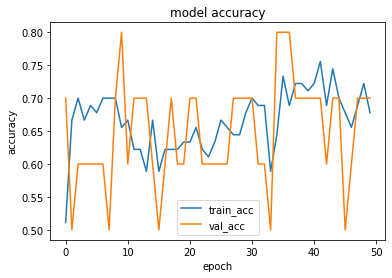

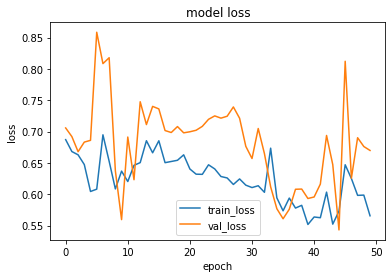

3/3 [==============================] - 0s 44ms/step - loss: 0.5933 - accuracy: 0.7111
evaluation on training data w/o augs:  [0.5933408737182617, 0.7111111283302307]
1/1 [==============================] - 0s 60ms/step - loss: 0.6699 - accuracy: 0.7000
evaluation on testing data:  [0.6698516011238098, 0.699999988079071]
1it [00:00, 17476.27it/s]
file is another_control.mov, prediction is [[0.44717115]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.48428932]]
1it [00:00, 16070.13it/s]
file is control_far.mov, prediction is [[0.437559]]
1it [00:00, 15650.39it/s]
file is long_armflapping.mov, prediction is [[0.31835914]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.18722826]]
1it [00:00, 17549.39it/s]
file is me_armflapping.mov, prediction is [[0.577205]]
Epoch 1/50
3/3 [==============================] - 1s 194ms/step - loss: 0.6883 - accuracy: 0.6222 - val_loss: 0.6671 - val_accuracy: 1.0000
Epoch 2/50
3/3 [======================

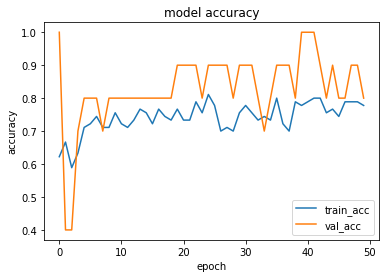

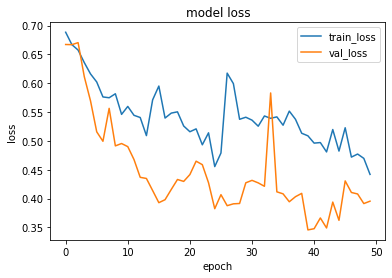

3/3 [==============================] - 0s 42ms/step - loss: 0.4668 - accuracy: 0.7667
evaluation on training data w/o augs:  [0.46676135063171387, 0.7666666507720947]
1/1 [==============================] - 0s 51ms/step - loss: 0.3954 - accuracy: 0.8000
evaluation on testing data:  [0.39540427923202515, 0.800000011920929]
1it [00:00, 14716.86it/s]
file is another_control.mov, prediction is [[0.3123908]]
1it [00:00, 16980.99it/s]
file is short_armflapping.mov, prediction is [[0.8015002]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.2872039]]
1it [00:00, 18808.54it/s]
file is long_armflapping.mov, prediction is [[0.3730499]]
1it [00:00, 17189.77it/s]
file is me_reading_control.mov, prediction is [[0.2880864]]
1it [00:00, 17549.39it/s]
file is me_armflapping.mov, prediction is [[0.85739046]]
Epoch 1/50
3/3 [==============================] - 1s 202ms/step - loss: 0.6898 - accuracy: 0.5889 - val_loss: 0.7209 - val_accuracy: 0.2000
Epoch 2/50
3/3 [=====================

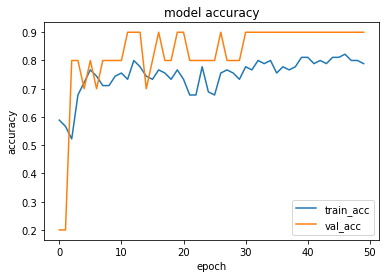

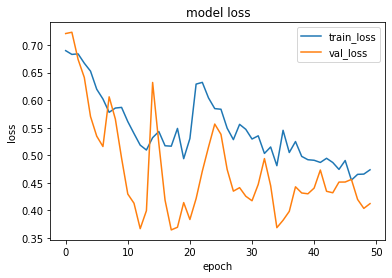

3/3 [==============================] - 0s 42ms/step - loss: 0.4359 - accuracy: 0.8111
evaluation on training data w/o augs:  [0.435910165309906, 0.8111110925674438]
1/1 [==============================] - 0s 60ms/step - loss: 0.4122 - accuracy: 0.9000
evaluation on testing data:  [0.4121526777744293, 0.8999999761581421]
1it [00:00, 15592.21it/s]
file is another_control.mov, prediction is [[0.32631546]]
1it [00:00, 17331.83it/s]
file is short_armflapping.mov, prediction is [[0.7235464]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.20964724]]
1it [00:00, 16644.06it/s]
file is long_armflapping.mov, prediction is [[0.55764526]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.22648308]]
1it [00:00, 17549.39it/s]file is me_armflapping.mov, prediction is [[0.7672361]]



In [128]:
for _ in range(3): 
    """here we will be using early stopping, augmentation""" 

    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode = "min", patience=10)

    model = tf.keras.models.Sequential([
        #TTAugmenter(rotation_range = None), # keep this for now, augmenter doesn't do much 
        tf.keras.layers.LSTM(16, return_sequences = False), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ]) # using lr 0.0005 works well with this setup

    model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy']) # see

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler() 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, verbose=1)

    plot(history)

    print("evaluation on training data w/o augs: ", model.evaluate(X_train, y_train))
    print('evaluation on testing data: ', model.evaluate(X_test, y_test))

    # high validation accuracy 
    # but not high testing accuracy

    from glob import glob
    for file in glob("*.mov"):
        print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [ ]:
predict_on_video(model, "/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/shorter_armflapping/_12.mp4")

In [ ]:
 /